In [41]:
!wget https://raw.githubusercontent.com/shtrausslearning/Data-Science-Portfolio/main/ANZ_internship/anz_data.csv

--2023-07-31 06:43:16--  https://raw.githubusercontent.com/shtrausslearning/Data-Science-Portfolio/main/ANZ_internship/anz_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2797503 (2.7M) [text/plain]
Saving to: ‘anz_data.csv.3’

anz_data.csv.3      100%[===================>]   2.67M  --.-KB/s    in 0.04s   

2023-07-31 06:43:17 (60.1 MB/s) - ‘anz_data.csv.3’ saved [2797503/2797503]



## Based on User Transaction Data Predict Annual Salary

### **Import Data**

Import data and do some preprocessing

In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def split_types(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']  
    numeric = df.select_dtypes(include=numerics)
    categorical = df.select_dtypes(exclude=numerics)
    return numeric,categorical

df_anz = pd.read_csv('/kaggle/working/anz_data.csv')
anz_debit = dict(tuple(df_anz.groupby('movement')))['debit']

df_anz['date'] = pd.to_datetime(df_anz['date'])
df_anz['card_present_flag'] = df_anz['card_present_flag'].fillna('none')
df_anz = df_anz.drop(['merchant_code'],axis=1)
df_anz['merchant_id'] = df_anz['merchant_id'].fillna('none')
df_anz['merchant_latitude'] = df_anz['merchant_latitude'].fillna('none')
df_anz['merchant_longitude'] = df_anz['merchant_longitude'].fillna('none')
df_anz['merchant_state'] = df_anz['merchant_state'].fillna('none')
df_anz['merchant_suburb'] = df_anz['merchant_suburb'].fillna('none')
df_anz.drop(['transaction_id'],axis=1,inplace=True)
df_anz

,account,age,amount,balance,card_present_flag,customer_id,date,first_name,gender,latitude,...,txn_description,bin_age,year,month,day,hour,minute,dow,payment_period,annual_salary
0,ACC-1598451071,26,16.25,35.39,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,...,POS,20-30,2018,8,1,1,1,Wednesday,7 days,52855.650000
1,ACC-1598451071,26,14.19,21.20,0.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,...,SALES-POS,20-30,2018,8,1,1,13,Wednesday,7 days,52855.650000
2,ACC-1598451071,26,3.25,17.95,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,...,SALES-POS,20-30,2018,8,1,1,51,Wednesday,7 days,52855.650000
3,ACC-1598451071,26,14.10,3.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,...,POS,20-30,2018,8,1,8,9,Wednesday,7 days,52855.650000
4,ACC-1598451071,26,10.67,1006.85,1.0,CUS-2487424745,2018-08-01,Diana,F,-27.95,...,POS,20-30,2018,8,1,18,19,Wednesday,7 days,52855.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,ACC-2153562714,24,3712.56,9707.77,none,CUS-423725039,2018-10-24,Linda,F,-31.88,...,PAY/SALARY,20-30,2018,10,24,14,0,Wednesday,30 days,45169.480000
12039,ACC-1217063613,27,4863.62,4863.86,none,CUS-1739931018,2018-09-26,Kimberly,F,-37.82,...,PAY/SALARY,20-30,2018,9,26,13,0,Wednesday,30 days,59174.043333
12040,ACC-1217063613,27,4863.62,8905.77,none,CUS-1739931018,2018-10-26,Kimberly,F,-37.82,...,PAY/SALARY,20-30,2018,10,26,13,0,Friday,30 days,59174.043333
12041,ACC-3100725361,25,6107.23,6111.57,none,CUS-2178051368,2018-09-26,Ronald,M,-17.03,...,PAY/SALARY,20-30,2018,9,26,15,0,Wednesday,30 days,74304.632000


In [234]:
# split by data types
values = split_types(df_anz)[0]
cats = split_types(df_anz)[1]

print(values.columns)
print(cats.columns)

Index(['age', 'amount', 'balance', 'latitude', 'longitude', 'year', 'month',
       'day', 'hour', 'minute', 'annual_salary'],
      dtype='object')
Index(['account', 'card_present_flag', 'customer_id', 'date', 'first_name',
       'gender', 'merchant_id', 'merchant_latitude', 'merchant_longitude',
       'merchant_state', 'merchant_suburb', 'movement', 'status',
       'txn_description', 'bin_age', 'dow', 'payment_period'],
      dtype='object')


### **Create Bin-based Categorical Data**

For visualisation, it helps to utilise bins

In [235]:
cats['annual_salary_bins'] = pd.cut(values['annual_salary'],bins=10)
mapper = dict(zip(cats['annual_salary_bins'].cat.categories,[f'category {i}' for i in range(10)]))
cats['annual_salary_bins'] = cats['annual_salary_bins'].map(mapper).astype('category')

### **Categorical Feature Encoding**

We have a lot of categorical features. Three possible approaches we could take are `LabelEncoder` `OneHotEncoder` & `OrdinalEncoder`

In [236]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

# encoder = LabelEncoder()
# enc_X = encoder.fit_transform(cats[['status']])
# enc_X = pd.Series(enc_X,name='status')

# encoder = OneHotEncoder()
# enc_X = encoder.fit_transform(cats[['status']]).toarray()
# enc_X = pd.DataFrame(enc_X)

# # add encodings
# values = pd.concat([values,enc_X],axis=1)
# values

In [237]:
# values.drop(['month','day','hour','minute','year'],axis=1,inplace=True)
# values.drop(['amount','balance','longitude','latitude','age'],axis=1,inplace=True)
values = values.drop(['annual_salary'],axis=1)

In [238]:
values

,age,amount,balance,latitude,longitude,year,month,day,hour,minute
0,26,16.25,35.39,-27.95,153.41,2018,8,1,1,1
1,26,14.19,21.20,-27.95,153.41,2018,8,1,1,13
2,26,3.25,17.95,-27.95,153.41,2018,8,1,1,51
3,26,14.10,3.85,-27.95,153.41,2018,8,1,8,9
4,26,10.67,1006.85,-27.95,153.41,2018,8,1,18,19
...,...,...,...,...,...,...,...,...,...,...
12038,24,3712.56,9707.77,-31.88,116.00,2018,10,24,14,0
12039,27,4863.62,4863.86,-37.82,147.61,2018,9,26,13,0
12040,27,4863.62,8905.77,-37.82,147.61,2018,10,26,13,0
12041,25,6107.23,6111.57,-17.03,145.73,2018,9,26,15,0


### **Dimension Reduction**

For input using `values` datafarame

In [239]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import MDS

# model = umap.UMAP(n_components=2)
# model = PCA(n_components=2)
# model = SpectralEmbedding(n_components=2)
model = TSNE(n_components=2)
# model = MDS(n_components=2, max_iter=100, n_init=1, normalized_stress="auto")

X = model.fit_transform(values)
X = pd.DataFrame(X)
X.columns = ['dim 1','dim 2']

# for plot readd all other data 
res = pd.concat([X,cats,values],axis=1)
res

,dim 1,dim 2,account,card_present_flag,customer_id,date,first_name,gender,merchant_id,merchant_latitude,...,age,amount,balance,latitude,longitude,year,month,day,hour,minute
0,-86.151344,30.162964,ACC-1598451071,1.0,CUS-2487424745,2018-08-01,Diana,F,81c48296-73be-44a7-befa-d053f48ce7cd,-27.99,...,26,16.25,35.39,-27.95,153.41,2018,8,1,1,1
1,-87.045113,29.455265,ACC-1598451071,0.0,CUS-2487424745,2018-08-01,Diana,F,830a451c-316e-4a6a-bf25-e37caedca49e,-33.87,...,26,14.19,21.20,-27.95,153.41,2018,8,1,1,13
2,-89.407646,30.326765,ACC-1598451071,1.0,CUS-2487424745,2018-08-01,Diana,F,b4e02c10-0852-4273-b8fd-7b3395e32eb0,-28.06,...,26,3.25,17.95,-27.95,153.41,2018,8,1,1,51
3,-87.362808,28.873337,ACC-1598451071,1.0,CUS-2487424745,2018-08-01,Diana,F,f2ef6270-cf91-409f-a6a2-fbd6735ea500,-28.63,...,26,14.10,3.85,-27.95,153.41,2018,8,1,8,9
4,-60.472683,23.460407,ACC-1598451071,1.0,CUS-2487424745,2018-08-01,Diana,F,44abc19c-aa5c-40bd-b1d0-9b2f236189ea,-28.01,...,26,10.67,1006.85,-27.95,153.41,2018,8,1,18,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,1.166599,67.336456,ACC-2153562714,none,CUS-423725039,2018-10-24,Linda,F,none,none,...,24,3712.56,9707.77,-31.88,116.00,2018,10,24,14,0
12039,-27.009378,77.982964,ACC-1217063613,none,CUS-1739931018,2018-09-26,Kimberly,F,none,none,...,27,4863.62,4863.86,-37.82,147.61,2018,9,26,13,0
12040,-2.047035,68.266647,ACC-1217063613,none,CUS-1739931018,2018-10-26,Kimberly,F,none,none,...,27,4863.62,8905.77,-37.82,147.61,2018,10,26,13,0
12041,-4.033413,68.402580,ACC-3100725361,none,CUS-2178051368,2018-09-26,Ronald,M,none,none,...,25,6107.23,6111.57,-17.03,145.73,2018,9,26,15,0


In [255]:
res.columns

Index(['dim 1', 'dim 2', 'account', 'card_present_flag', 'customer_id', 'date',
       'first_name', 'gender', 'merchant_id', 'merchant_latitude',
       'merchant_longitude', 'merchant_state', 'merchant_suburb', 'movement',
       'status', 'txn_description', 'bin_age', 'dow', 'payment_period',
       'annual_salary_bins', 'age', 'amount', 'balance', 'latitude',
       'longitude', 'year', 'month', 'day', 'hour', 'minute', 'cluster_a'],
      dtype='object')

### **Clusterisation**

Cluster our data into groups

In [287]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

# data connectivity information
connectivity = kneighbors_graph(X, n_neighbors=100, 
                                include_self=False)

cmodel = AgglomerativeClustering(n_clusters=5,connectivity=connectivity)
res['cluster_a'] = cmodel.fit_predict(res[['dim 1','dim 2']])

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


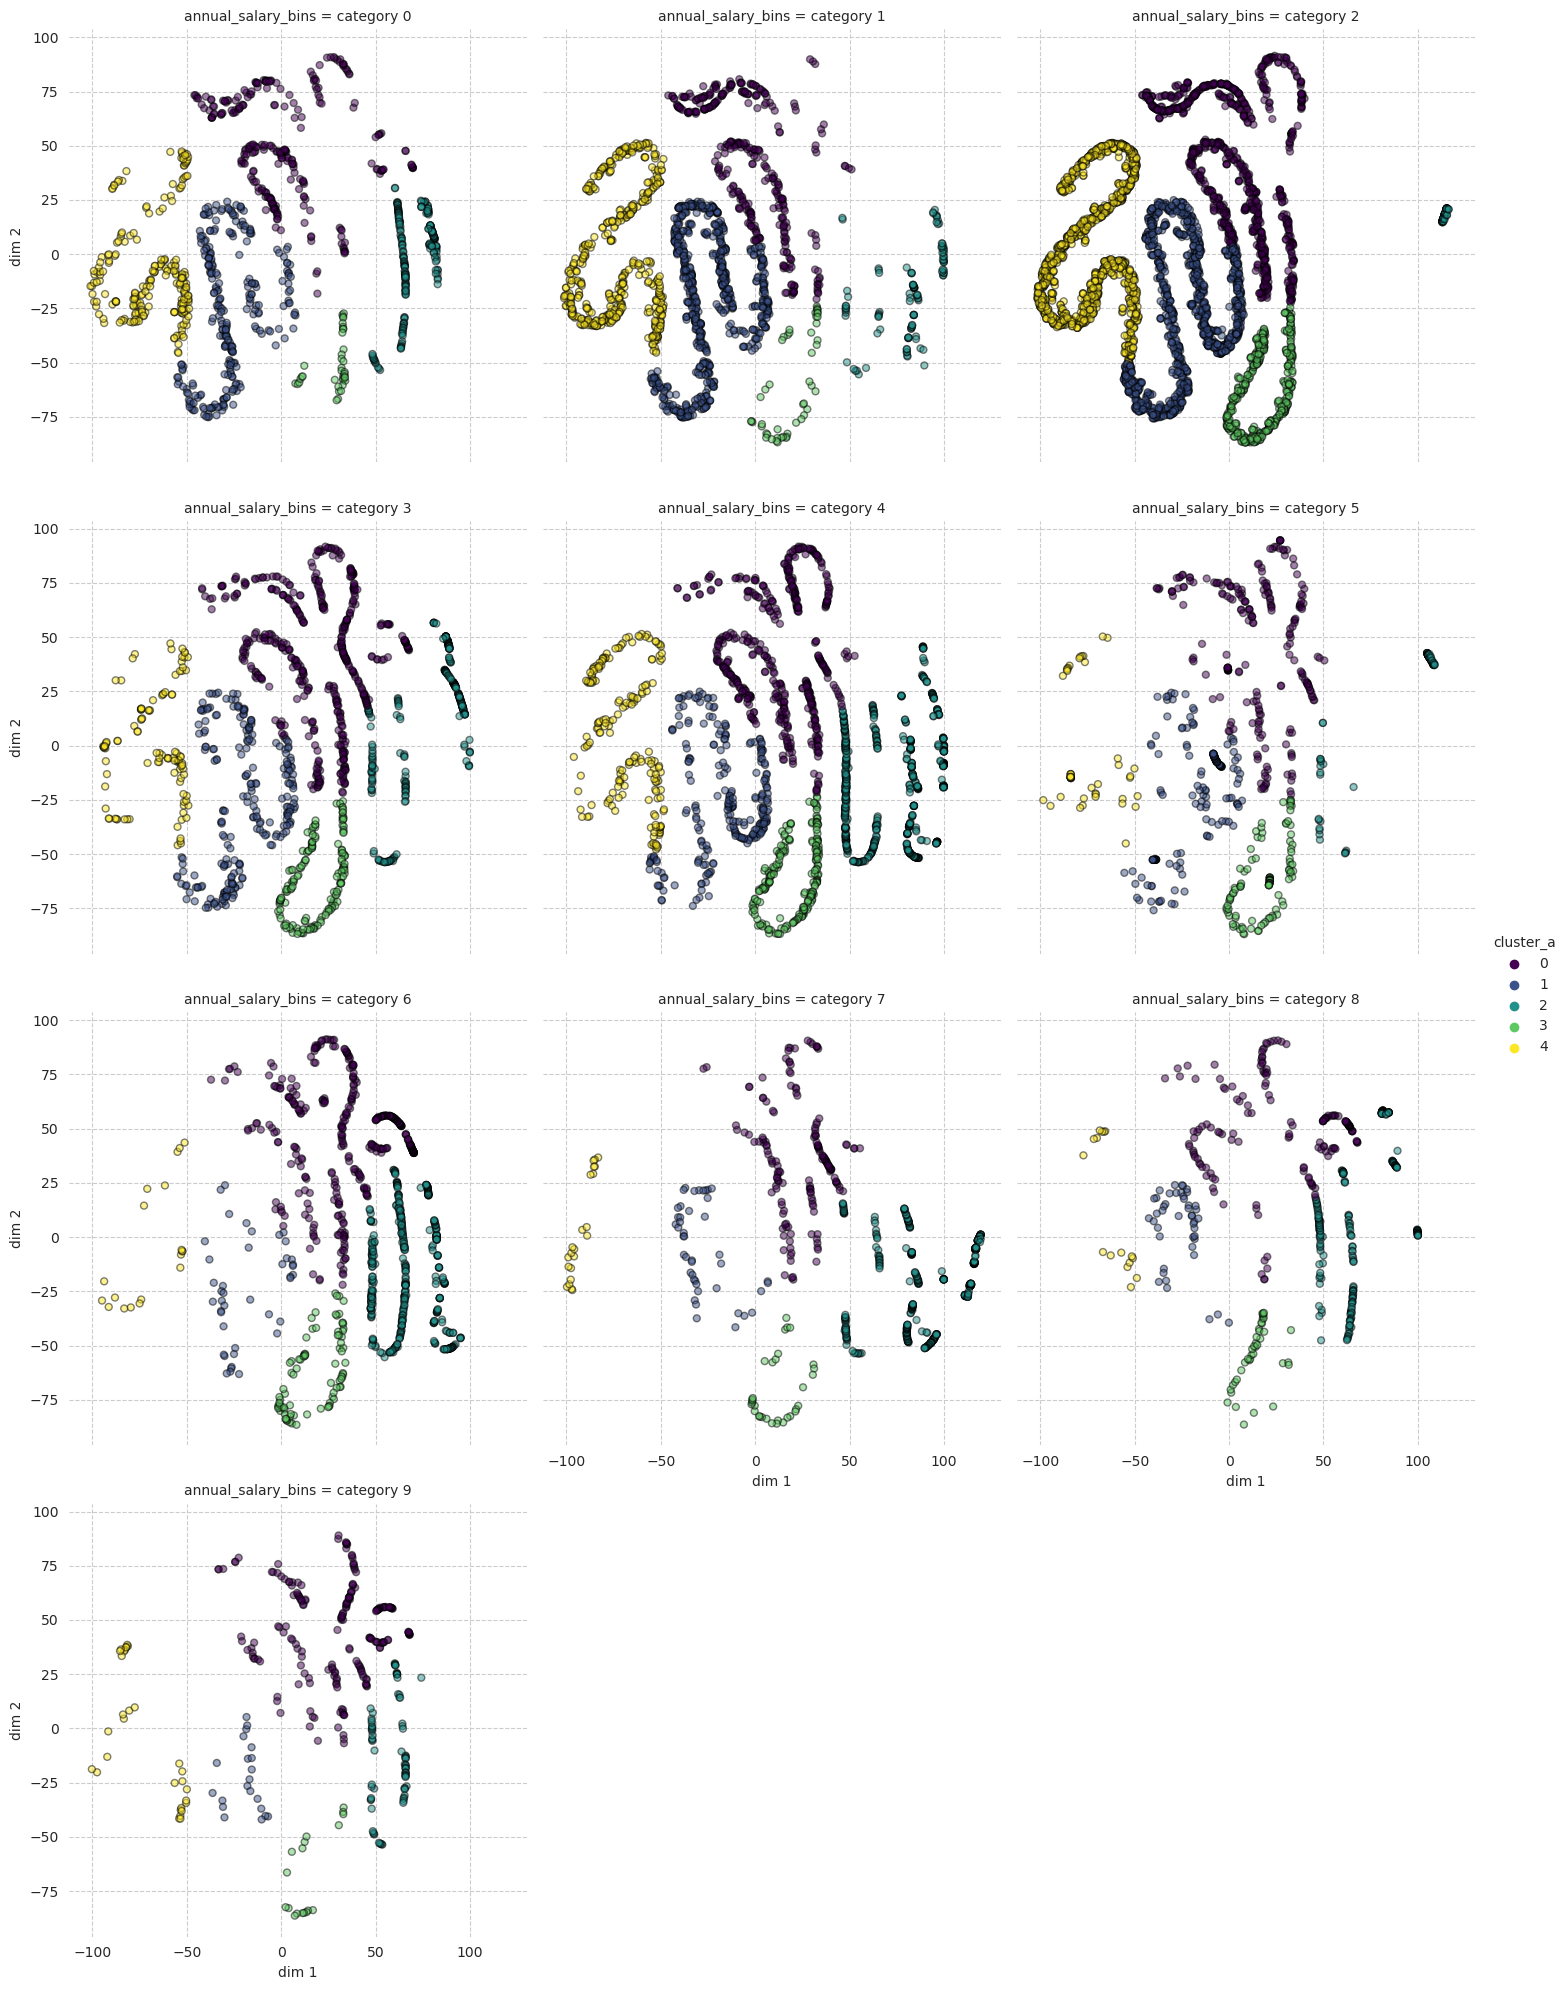

In [288]:
# visualise two dimension dimension reduction plot

def plot_dimred(res):

    sns.relplot(res,
                x='dim 1',y='dim 2',
                linewidth=1,
                edgecolor='k',
                alpha=0.5,
                col='annual_salary_bins',
                col_wrap=3,
                palette='viridis',
                legend='brief',
                hue='cluster_a',
                s=25)

    sns.set_style("whitegrid", {
                "ytick.major.size": 0.1,
                "ytick.minor.size": 0.05,
                'grid.linestyle': '--'})
    sns.despine(left=True, bottom=True)
    
plot_dimred(res)

### **Create Machine Learning Model**

- Split the data into two subgroups (90/10)
- Utilise an enseble of `DecisionTreeRegressors`
- Evaluate the model's generalisation performance on the test set

In [321]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split as tts
import pickle

def quick_model(X,y):

    X_train,X_test,y_train,y_test = tts(X,y,test_size=0.1)
#     model_lr = LinearRegression()
#     model_lr = DecisionTreeRegressor()
    model_lr = RandomForestRegressor()
    
    model_lr.fit(X_train,y_train)
    ymodel = model_lr.predict(X_test)
    print('1. Entire Dataset Model')
    print(f'RMSE error: {MSE(y_test,ymodel,squared=False)}')
    print(f'R2 error: {model_lr.score(X,y)}')

   # filename = 'finalized_model.sav'
   # pickle.dump(model, open(filename, 'wb'))
    
    #print(model.predict(X_test[1]))
   # print(y_test[1])

In [322]:
X_model,y_model = pd.concat([values,X],axis=1), df_anz['annual_salary'] 
quick_model(X_model.values,y_model.values)

1. Entire Dataset Model
RMSE error: 2265.0879494407463
R2 error: 0.9987948172155021


- Such an approach is not actually viable since TSNE doesn't support `transform` so if new data is available, we need to refit on the entire dataset again, so the approach doesn't scale with large datasets
- Nevertheless, the additional of TNSE features actually reduced the generalisation performance even more than that obtained in the main notebook, no other dimensionality reduction approach improved the score